In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

def get_drawdown(p):
    """
    计算净值回撤
    """
    T = len(p)
    hmax = [p[0]]
    for t in range(1, T):
        hmax.append(np.nanmax([p[t], hmax[t - 1]]))
    dd = [p[t] / hmax[t] - 1 for t in range(T)]

    return dd


def cal_period_perf_indicator(adjnav):
    """
    计算区间业绩指标:输入必须是日频净值
    """

    if type(adjnav) == pd.DataFrame:
        res = pd.DataFrame(index=adjnav.columns, columns=['AnnRet', 'AnnVol', 'SR', 'MaxDD', 'Calmar'])
        for col in adjnav:
            res.loc[col] = cal_period_perf_indicator(adjnav[col])
        res = res.applymap(float_to_percent)
        return res

    ret = adjnav.pct_change()
    #annret = np.nanmean(ret) * 242 # 单利
    annret = (adjnav[-1] / adjnav[0]) ** (242/len(adjnav)) - 1 # 复利
    annvol = np.nanstd(ret) * np.sqrt(242)
    sr = annret / annvol
    dd = get_drawdown(adjnav)
    mdd = np.nanmin(dd)
    calmar = annret / -mdd

    return [annret, annvol, sr, mdd, calmar]

def datestr2dtdate(datestr):
    # 日期格式转换：'yyyy-mm-dd'转为datetime.date
    return datetime.datetime.strptime(datestr, '%Y-%m-%d').date()

# Define a formatting function to convert float to percentage
def float_to_percent(x):
    return "{:.2%}".format(x)


,AnnRet,AnnVol,SR,MaxDD,Calmar
asset,3.44%,30.02%,11.48%,-82.69%,4.17%
stgy,2.43%,15.28%,15.90%,-56.68%,4.29%


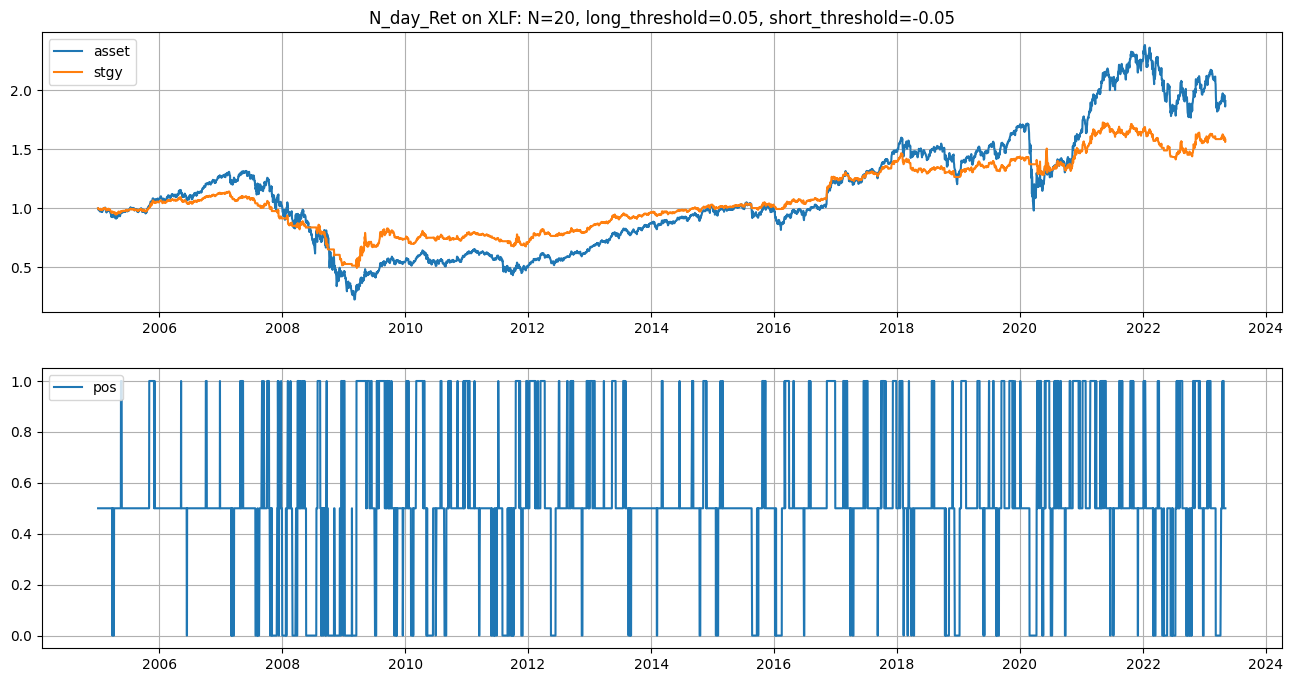

In [27]:
# 从csv文件获取指数价格数据
index_data = pd.read_csv('USD ETFs.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

################################################################
# 近期涨幅 
index_id = 'XLF'
N = 20
long_threshold = 0.05
short_threshold = -0.05

df = index_data.loc[:,[index_id]]
df['ret'] = df[index_id].pct_change()
df['asset'] = (1+df['ret']).cumprod().fillna(1)
df['N_day_ret'] = df['asset'] / df['asset'].shift(N) - 1
df['pos'] = [1 if e>long_threshold else 0 if e<short_threshold else 0.5 for e in df['N_day_ret'].shift(1)]
df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1+df['stgy_ret']).cumprod().fillna(1)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,['asset','stgy']].plot(ax=ax1, grid=True, title='N_day_Ret on %s: N=%d, long_threshold=%.2f, short_threshold=%.2f' % (index_id, N,long_threshold,short_threshold))
ax2 = fig.add_subplot(2,1,2)
df.loc[:,['pos']].plot(ax=ax2, grid=True)
res = cal_period_perf_indicator(df.loc[:,['asset','stgy']])
res



,AnnRet,AnnVol,SR,MaxDD,Calmar
asset,3.44%,30.02%,11.48%,-82.69%,4.17%
stgy,4.19%,13.92%,30.09%,-36.49%,11.48%


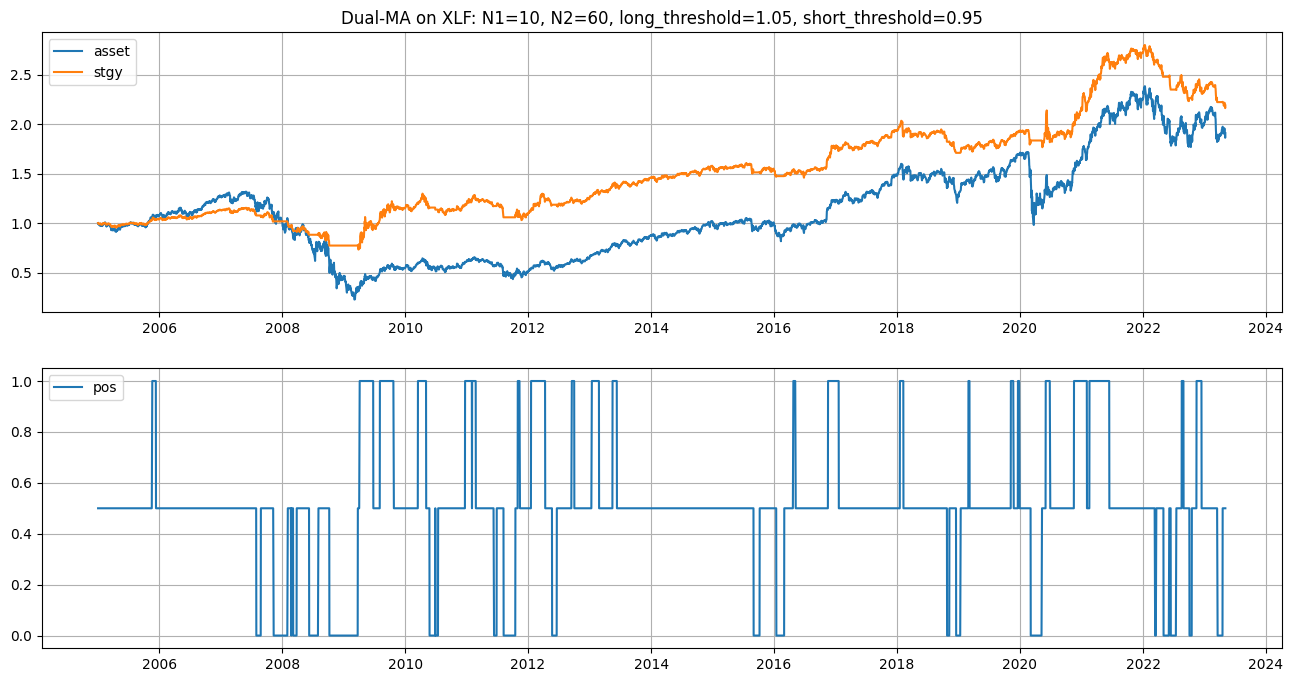

In [29]:

################################################################
# 双均线系统
index_id = 'XLF'
N1 = 10
N2 = 60
long_threshold = 1.05
short_threshold = 0.95

df = index_data.loc[:,[index_id]]
df['ret'] = df[index_id].pct_change()
df['asset'] = (1+df['ret']).cumprod().fillna(1)
df['ret'] = df['asset'].pct_change()
df['MA1'] = df['asset'].rolling(window=N1).mean()
df['MA2'] = df['asset'].rolling(window=N2).mean()
df['MA1/MA2'] = df['MA1'] / df['MA2']
df['pos'] = [1 if e>long_threshold else 0 if e<short_threshold else 0.5 for e in df['MA1/MA2'].shift(1)]
df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1+df['stgy_ret']).cumprod().fillna(1)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,['asset','stgy']].plot(ax=ax1, grid=True, title='Dual-MA on %s: N1=%d, N2=%d, long_threshold=%.2f, short_threshold=%.2f' % (index_id, N1, N2, long_threshold, short_threshold))
ax2 = fig.add_subplot(2,1,2)
df.loc[:,['pos']].plot(ax=ax2, grid=True)
res = cal_period_perf_indicator(df.loc[:,['asset','stgy']])
res




,AnnRet,AnnVol,SR,MaxDD,Calmar
asset,-5.16%,40.61%,-12.70%,-95.29%,-5.41%
stgy,4.88%,22.81%,21.39%,-70.44%,6.93%


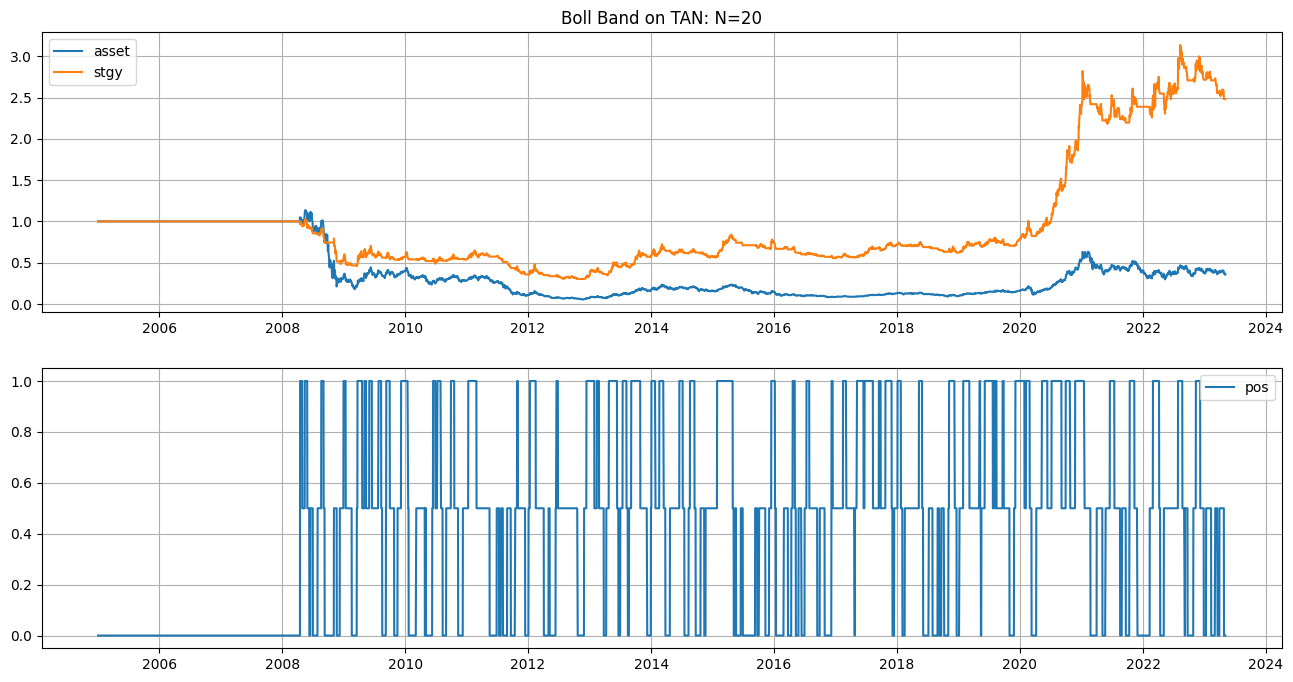

In [47]:

################################################################
# 布林带
N = 20
index_id = 'TAN'

df = index_data.loc[:,[index_id]]
df['ret'] = df[index_id].pct_change()
df['asset'] = (1+df['ret']).cumprod().fillna(1)
df['ret'] = df['asset'].pct_change()
df['MA'] = df['asset'].rolling(window=N).mean()
df['std'] = df['asset'].rolling(window=N).std()
df['up'] = df['MA'] + 2 * df['std']
df['down'] = df['MA'] - 2 * df['std']
df['pos'] = 0
for i in range(1,len(df)):
    t = df.index[i]
    t0 = df.index[i-1]
    if df.loc[t0,'asset'] > df.loc[t0,'up']:
        df.loc[t,'pos'] = 1
    elif df.loc[t0,'asset'] < df.loc[t0,'down']:
        df.loc[t,'pos'] = 0
    elif df.loc[t0,'pos']==1 and df.loc[t0,'asset']<df.loc[t0,'MA']:
        df.loc[t,'pos'] = 0.5
    elif df.loc[t0,'pos']==0 and df.loc[t0,'asset']>df.loc[t0,'MA']:
        df.loc[t,'pos'] = 0.5
    else:
        df.loc[t,'pos'] = df.loc[t0,'pos']
df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1+df['stgy_ret']).cumprod().fillna(1)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,['asset','stgy']].plot(ax=ax1, grid=True, title='Boll Band on %s: N=%d' % (index_id, N))
ax2 = fig.add_subplot(2,1,2)
df.loc[:,['pos']].plot(ax=ax2, grid=True)
res = cal_period_perf_indicator(df.loc[:,['asset','stgy']])
res

